In [1]:
import pandas as pd
import json
from glob import glob
import pathlib as pl
from types import SimpleNamespace
import seaborn as sns
import matplotlib.pyplot as plt
import periodictable as ptable
import numpy as np
from matplotlib.ticker import LogFormatter

pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.10f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
sns.set_context('talk')

In [2]:
dir_root = pl.Path('').absolute()
dir_calc_mw = dir_root.joinpath('calcs_zora_mw8_take1')
dir_calc_gto = dir_root.joinpath('calcs_zora_gto_defgrid3')

basis_sets = ['ugbs', 'ano-r3', 'ano-rcc-vqzp', 'sapporo-qzp-2012-diffuse', 'sarc-zora-tzvpp']

EXCLUDE_FILES = []

atoms = ['Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'I', 'Xe']
nelecs    = [37+i for i in range(18)]

In [3]:
def MWEnergy(f):
    try:
        with open(f) as out:
            job = json.loads(out.read())
    except FileNotFoundError:
        return None
    try:
        if job['output']['success']:
            return float(job['output']['properties']['scf_energy']['E_tot'])
        else:
            return None
    except KeyError:
        return None

def GTOEnergy(f):
    try:
        with open(f) as out:
            lines = out.readlines()
    except FileNotFoundError:
        return None
    for line in lines:
        if line.strip().startswith('FINAL SINGLE POINT ENERGY'):
            return float(line.split()[4])
        
def numberOfSCFIterations(f):
    try:
        with open(f) as out:
            job = json.loads(out.read())
    except FileNotFoundError:
        return None
    try:
        if job['output']['success']:
            return str(len(job['output']['scf_calculation']['scf_solver']['cycles']))
        else:
            return None
    except KeyError:
        return None
    
def convData(f):
    try:
        with open(f) as out:
            job = json.loads(out.read())
    except FileNotFoundError:
        return None, None
    try:
        if job['output']['success']:
            update = job['output']['scf_calculation']['scf_solver']['cycles'][-1]['energy_update']
            residual = job['output']['scf_calculation']['scf_solver']['cycles'][-1]['mo_residual']
            return update, residual
        else:
            return None, None
    except KeyError:
        return None, None

In [4]:
table = []
for atom in atoms:
    for basis in basis_sets:
        f_gto = dir_calc_gto.joinpath(f'{atom}_{basis}_pbe.out')
        e_gto = GTOEnergy(f_gto) if f_gto.name not in EXCLUDE_FILES else None
        f_mw = dir_calc_mw.joinpath(f'{atom}_pbe.json')
        e_mw = MWEnergy(f_mw)
        niter = numberOfSCFIterations(f_mw)
        update, residual = convData(f_mw)

        table.append((atom, niter, update, residual, basis, e_gto, e_mw))

In [5]:
df = pd.DataFrame(table, columns=['Atom', 'nIter', 'Update', 'Residual', 'GTOBasis', 'Energy_GTO', 'Energy_MW8'])
df['Error'] = abs(df['Energy_GTO'] - df['Energy_MW8'])

df.Update = df.Update.map(lambda x: f'{x:.3e}')
df.Residual = df.Residual.map(lambda x: f'{x:.3e}')

In [6]:
df[["Atom", "GTOBasis", "Energy_GTO", "Energy_MW8"]].to_csv("data_row5_MWs_vs_GTOs.csv", index=False)

In [7]:
for atom, g in df.groupby('Atom'):
    print('-------------------------------------------------------------------------------------------------------')
    print(g.to_string(index=False))
print('-------------------------------------------------------------------------------------------------------')

-------------------------------------------------------------------------------------------------------
Atom nIter    Update  Residual                 GTOBasis       Energy_GTO       Energy_MW8         Error
  Ag    10 6.856e-08 1.023e-06                     ugbs -5405.3615765886 -5405.3863408027  0.0247642142
  Ag    10 6.856e-08 1.023e-06                   ano-r3 -5394.7635206459 -5405.3863408027 10.6228201569
  Ag    10 6.856e-08 1.023e-06             ano-rcc-vqzp -5389.5723432743 -5405.3863408027 15.8139975284
  Ag    10 6.856e-08 1.023e-06 sapporo-qzp-2012-diffuse -5378.9246746680 -5405.3863408027 26.4616661347
  Ag    10 6.856e-08 1.023e-06          sarc-zora-tzvpp -5404.9929999642 -5405.3863408027  0.3933408385
-------------------------------------------------------------------------------------------------------
Atom nIter    Update  Residual                 GTOBasis       Energy_GTO       Energy_MW8         Error
  Cd     9 8.024e-08 2.361e-06                     ugbs -5692.38

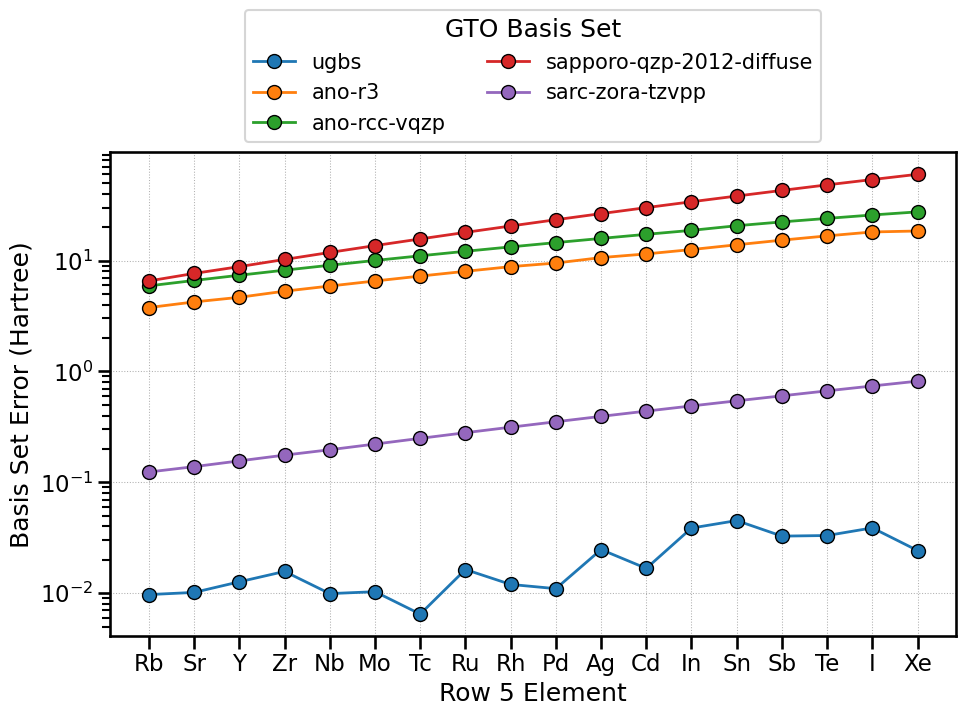

In [8]:
fig, ax = plt.subplots(figsize=(10, 7.5), dpi=100)
ax.grid(lw=0.75, ls=':')
ax.set_yscale('log')

ax.set_ylabel('Basis Set Error (Hartree)')
ax.set_xlabel('Row 5 Element')

basis_sets = df.GTOBasis.unique().tolist()
colors = sns.color_palette(n_colors=len(basis_sets)).as_hex()

for basis, color in zip(basis_sets, colors):
    sub = df.loc[df.GTOBasis == basis]
    ax.plot(sub.Atom, sub.Error, color=color, mec='black', marker='o', lw=2, ms=10, label=basis)
    
ax.legend(title='GTO Basis Set', loc='lower center', bbox_to_anchor=(0.5, 1), fontsize='small', ncol=2)

fig.tight_layout()
fig.savefig('MRChem_vs_ORCA_Take1.png', facecolor='white')

In [9]:
# Orbital energies
def mw_orbital_energies(j):
    data = {'a': [], 'b': []}
    with open(j) as f:
        job = json.loads(f.read())
        
    d = job['output']['properties']['orbital_energies']
    for e, spin in zip(d['energy'], d['spin']):
        data[spin].append(float(e))
    return data

def gto_orbital_energies(f):
    with open(f) as file:
        lines = [line.strip() for line in file.readlines()]
        
    data = {'a': [], 'b': []}
    spin = 'a'
    for i, line in enumerate(lines):
        if line.startswith('ORBITAL ENERGIES'):
            for subline in lines[i+4:]:
                if subline.startswith('SPIN UP ORBITALS'):
                    spin = 'a'
                elif subline.startswith('SPIN DOWN ORBITALS'):
                    spin = 'b'
                try:
                    if int(float(subline.split()[1])) == 1:
                        data[spin].append(float(subline.split()[2]))
                except (IndexError, ValueError):
                    continue
    return data


    \begin{figure}[H]
        \centering
        \includegraphics[height=0.75\textheight]{figs/gto_orbital_errors_Rb.png}
        \caption{Basis set errors presented as unsigned deviations (UD, green line, in Hartrees) and relative unsigned deviations (RUD, red line, in percent) in orbital energies for Rb.}
        \label{fig:orbital_errors_Rb}
    \end{figure}
    

    \begin{figure}[H]
        \centering
        \includegraphics[height=0.75\textheight]{figs/gto_orbital_errors_Sr.png}
        \caption{Basis set errors presented as unsigned deviations (UD, green line, in Hartrees) and relative unsigned deviations (RUD, red line, in percent) in orbital energies for Sr.}
        \label{fig:orbital_errors_Sr}
    \end{figure}
    

    \begin{figure}[H]
        \centering
        \includegraphics[height=0.75\textheight]{figs/gto_orbital_errors_Y.png}
        \caption{Basis set errors presented as unsigned deviations (UD, green line, in Hartrees) and relative unsigned deviations (RUD, re

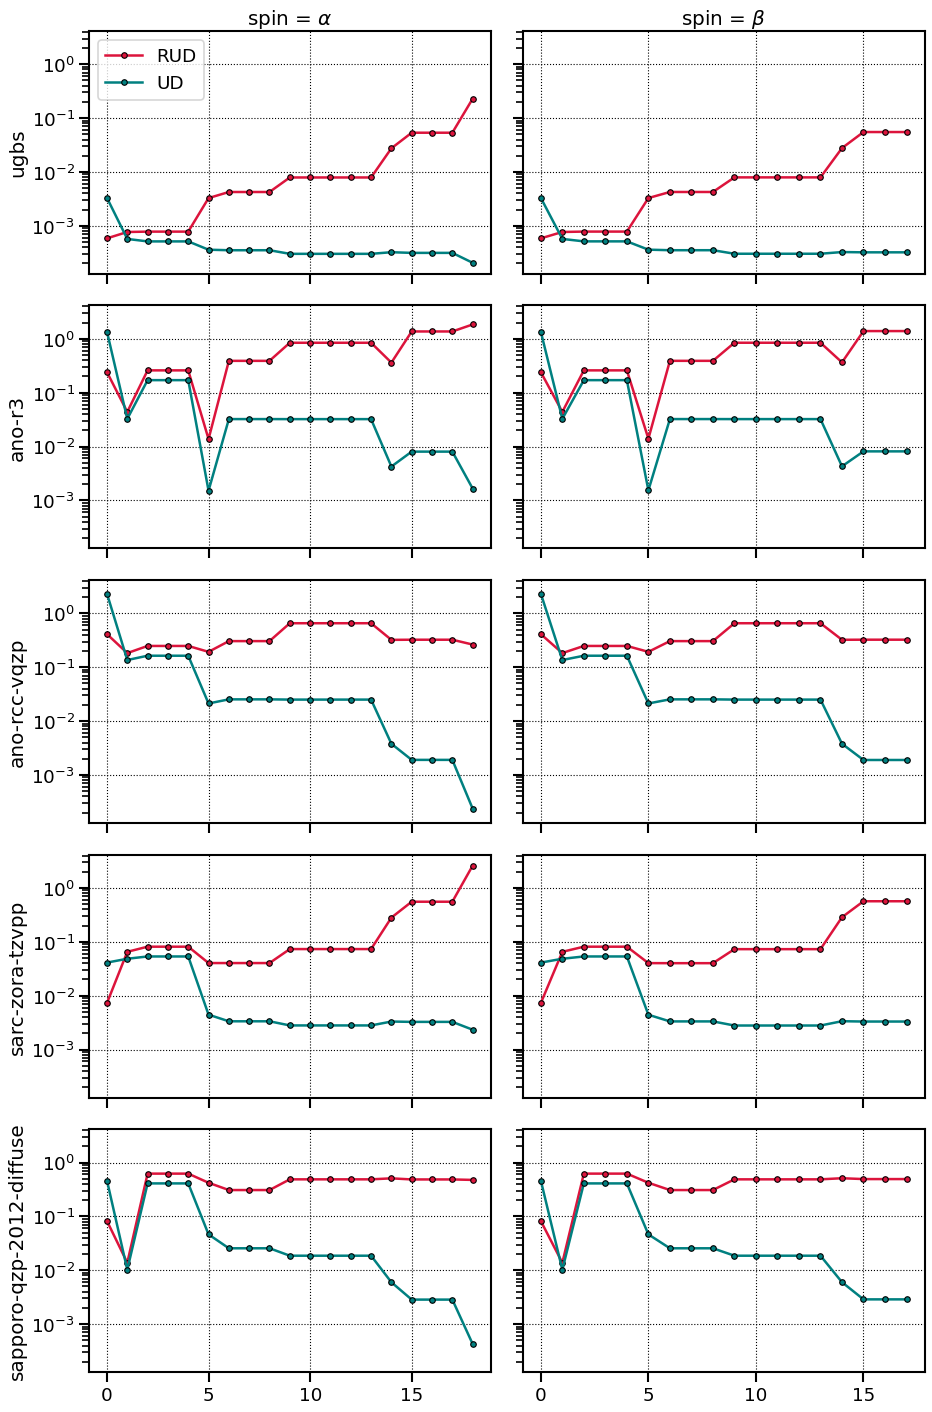

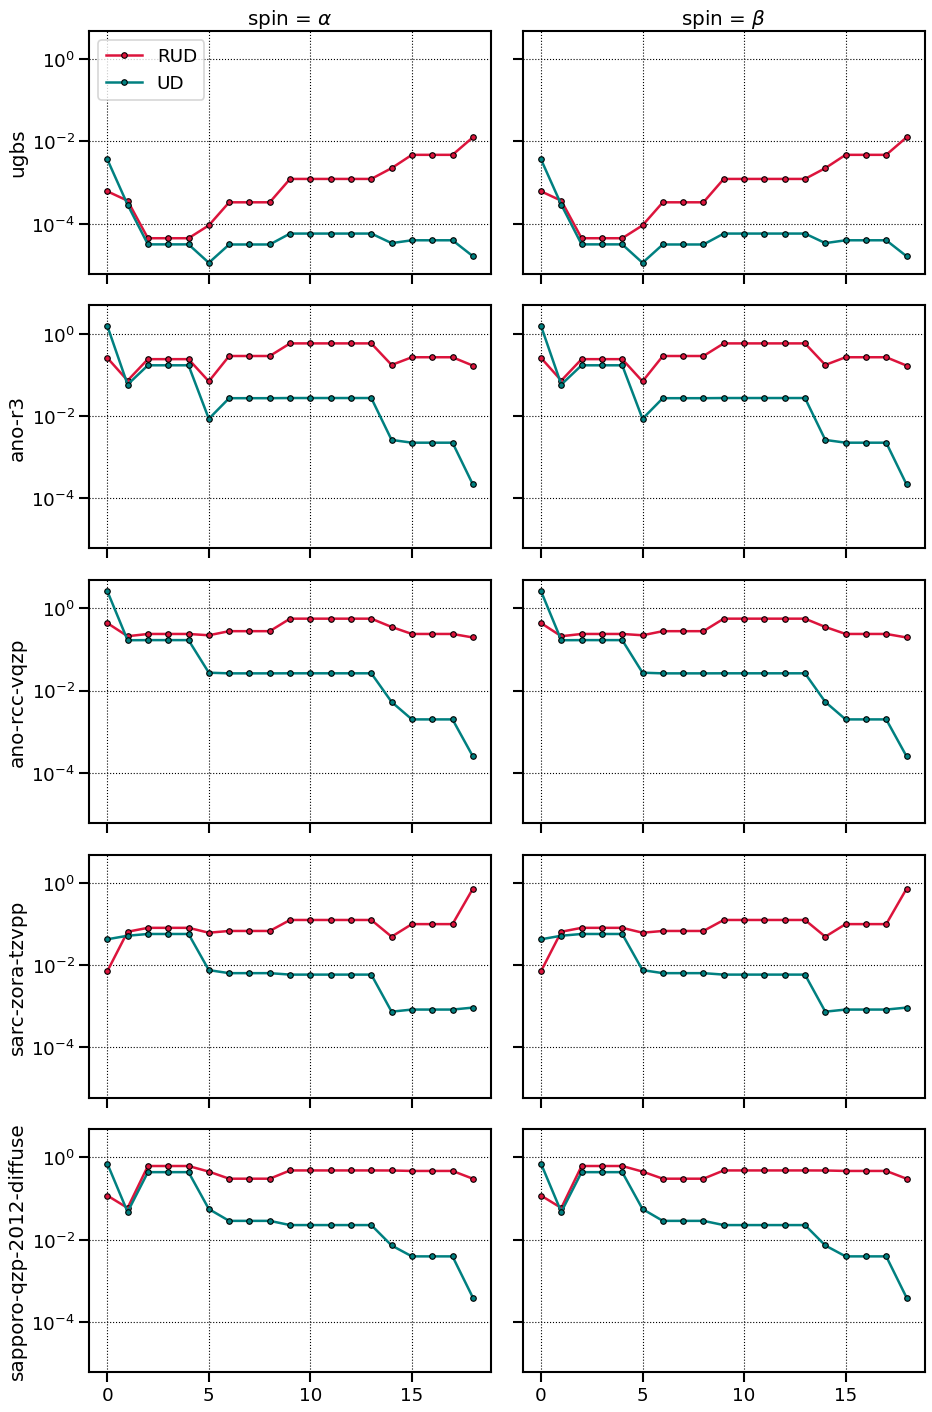

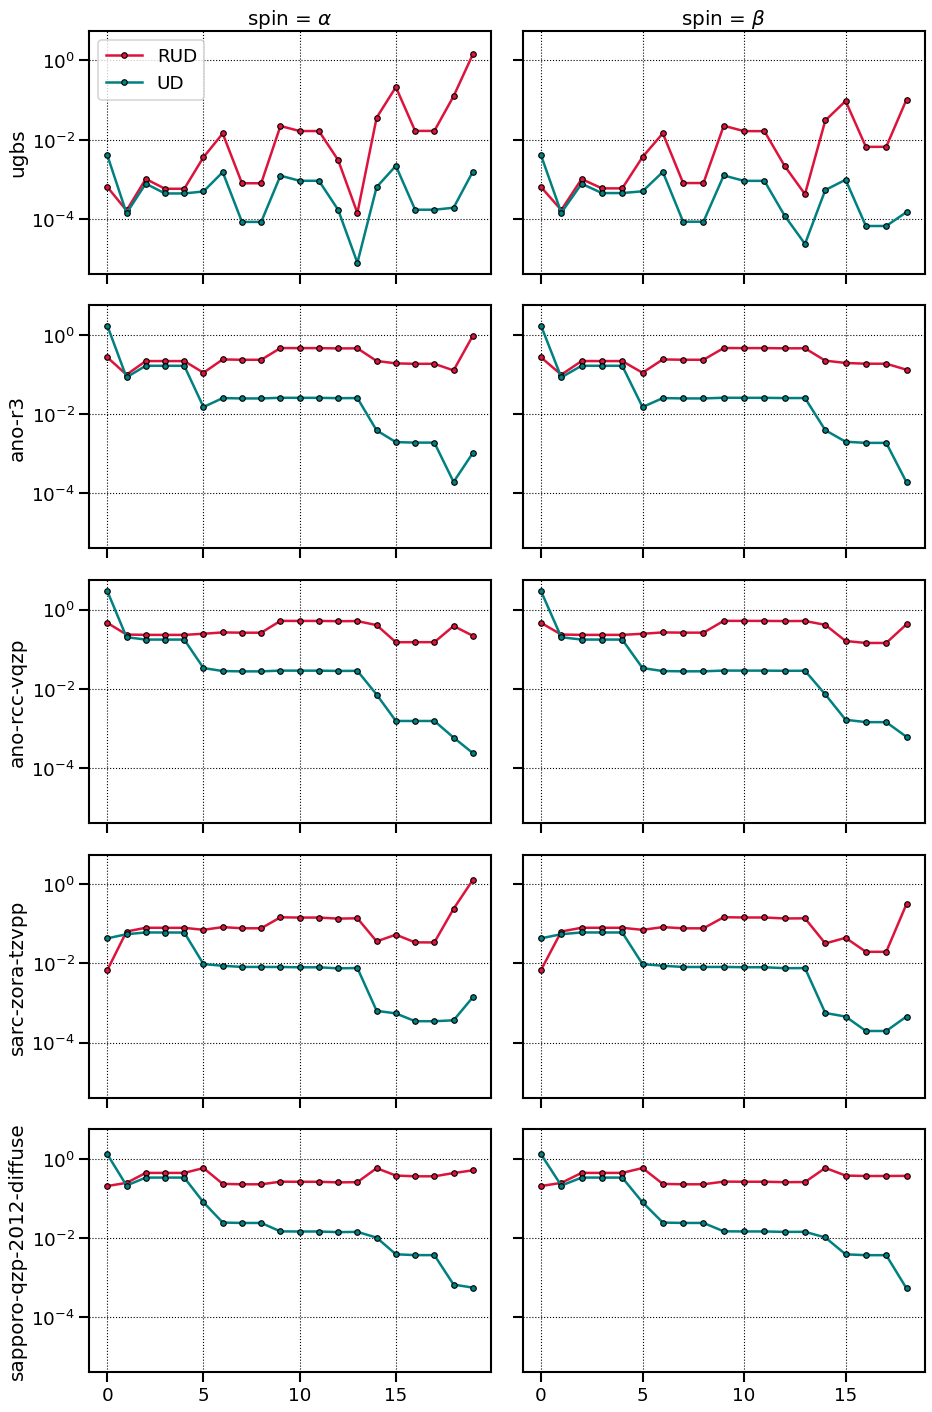

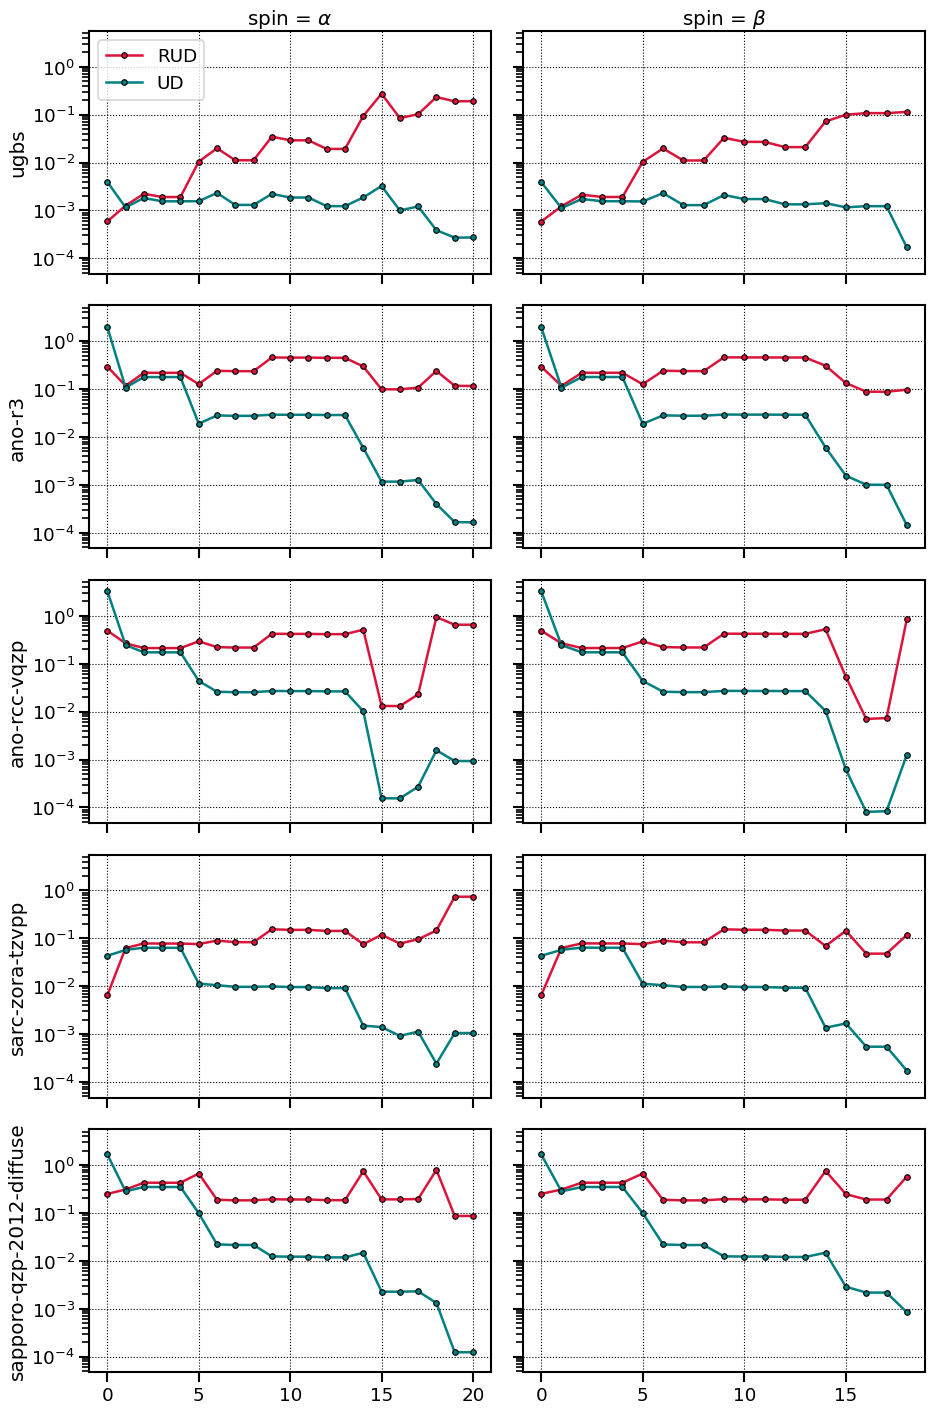

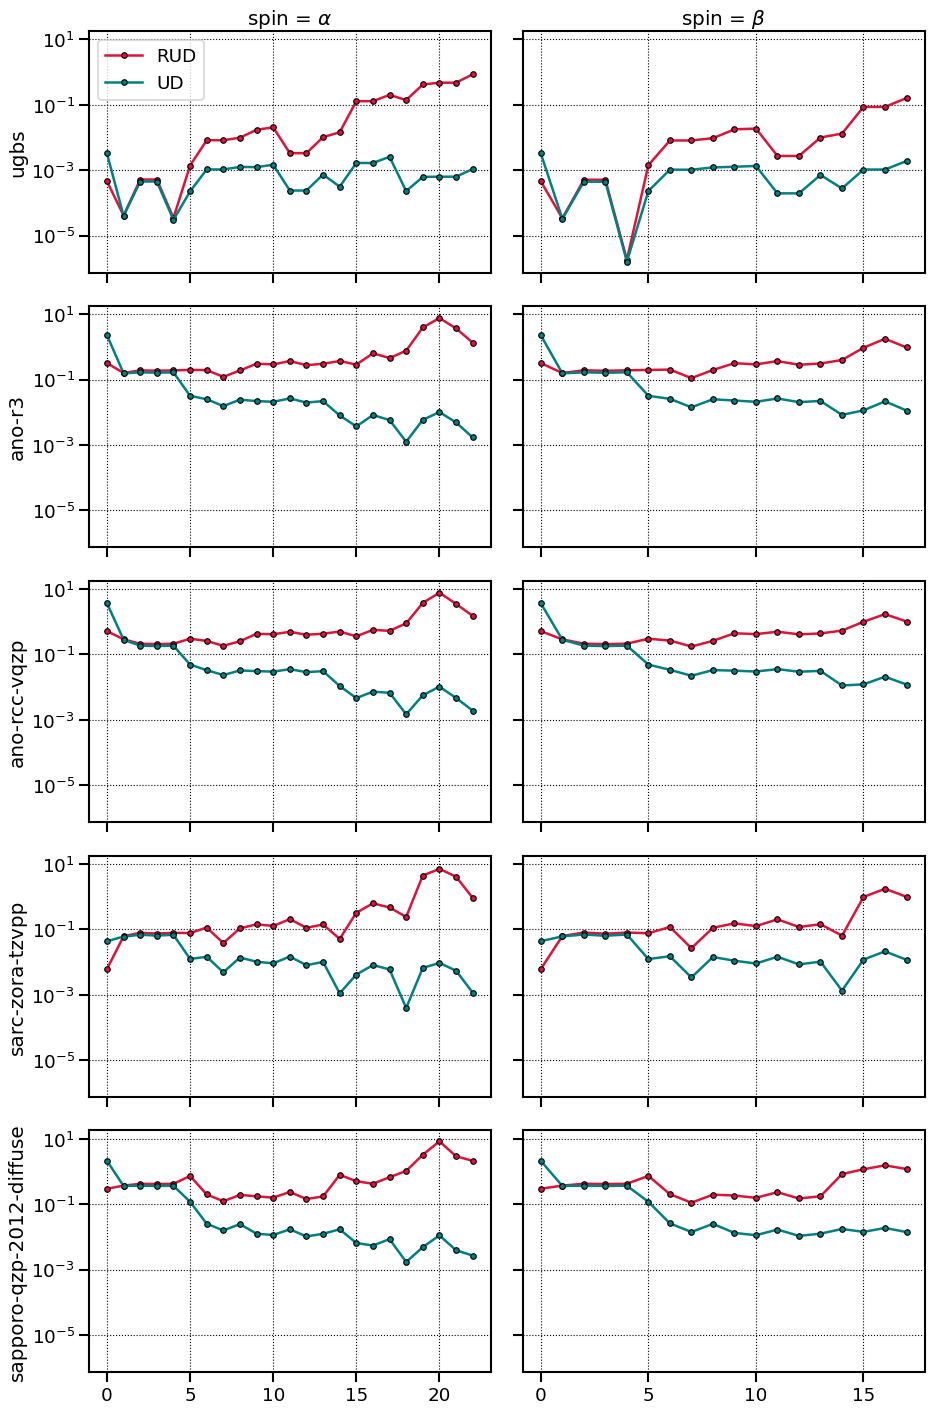

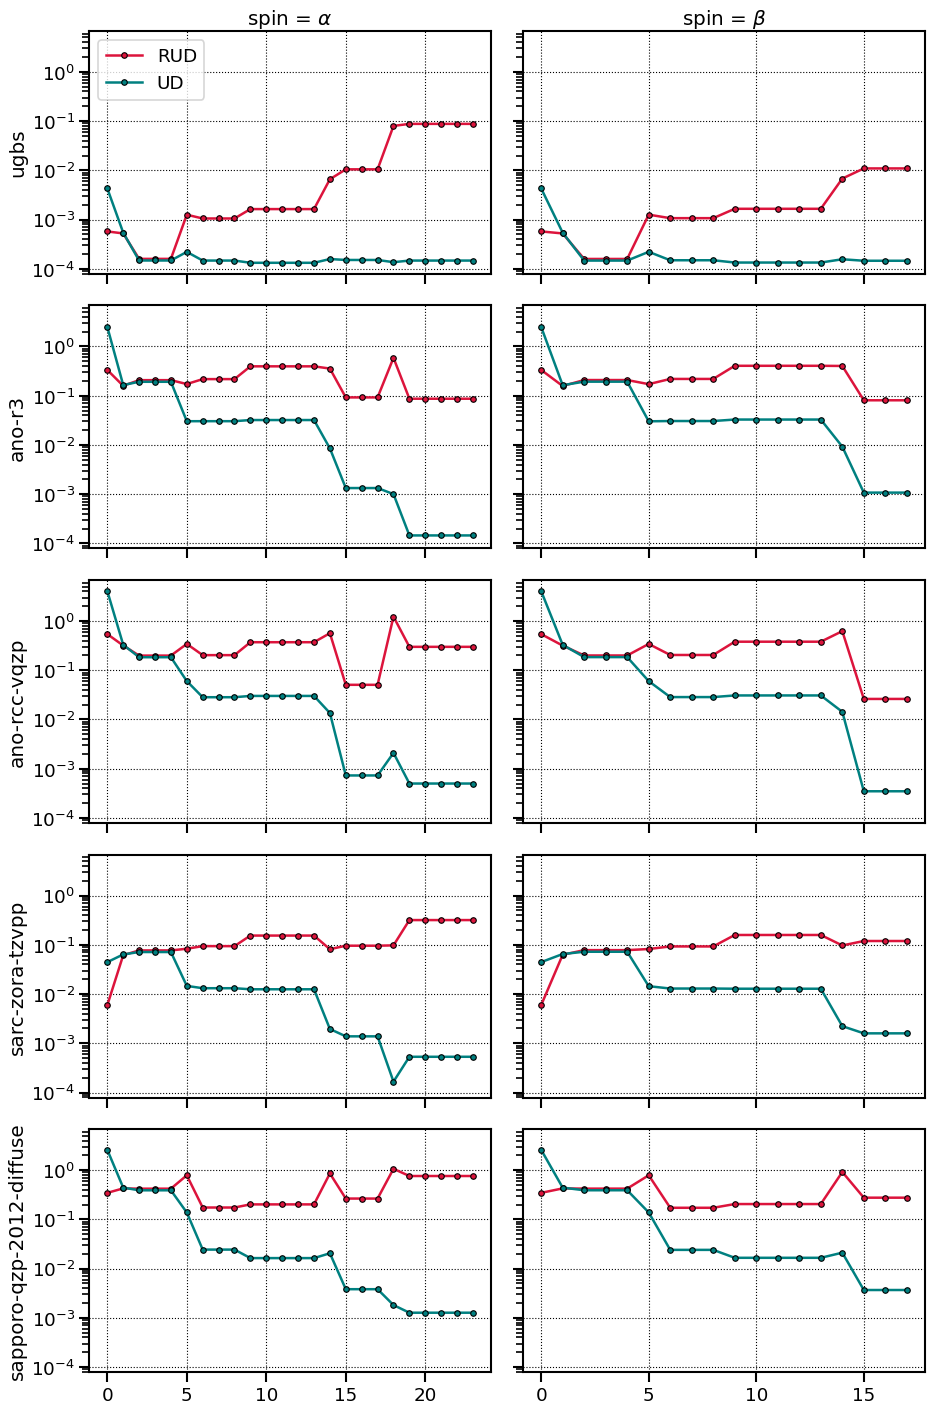

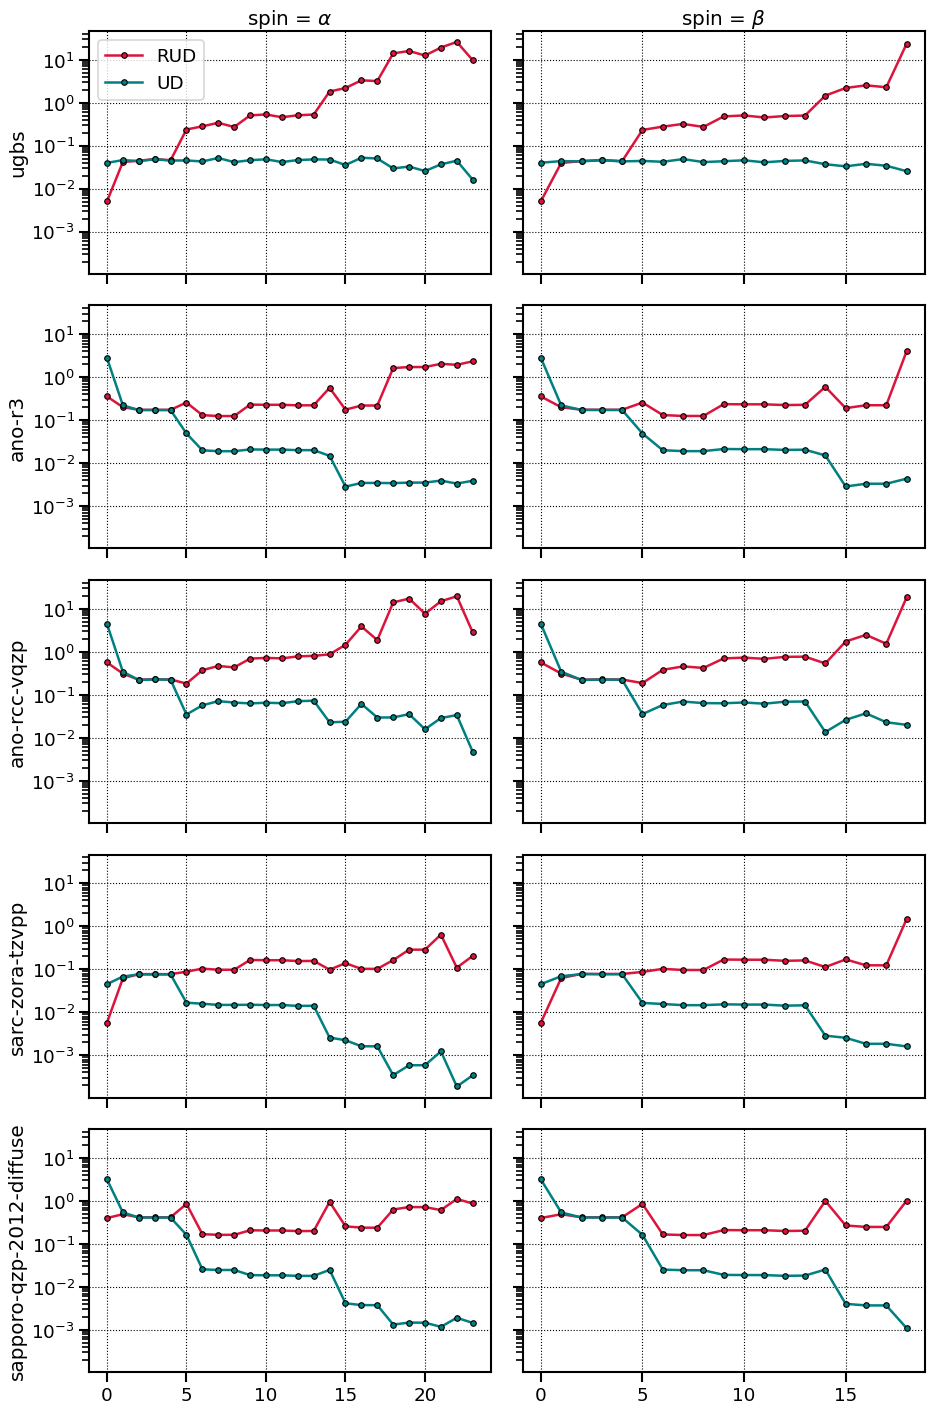

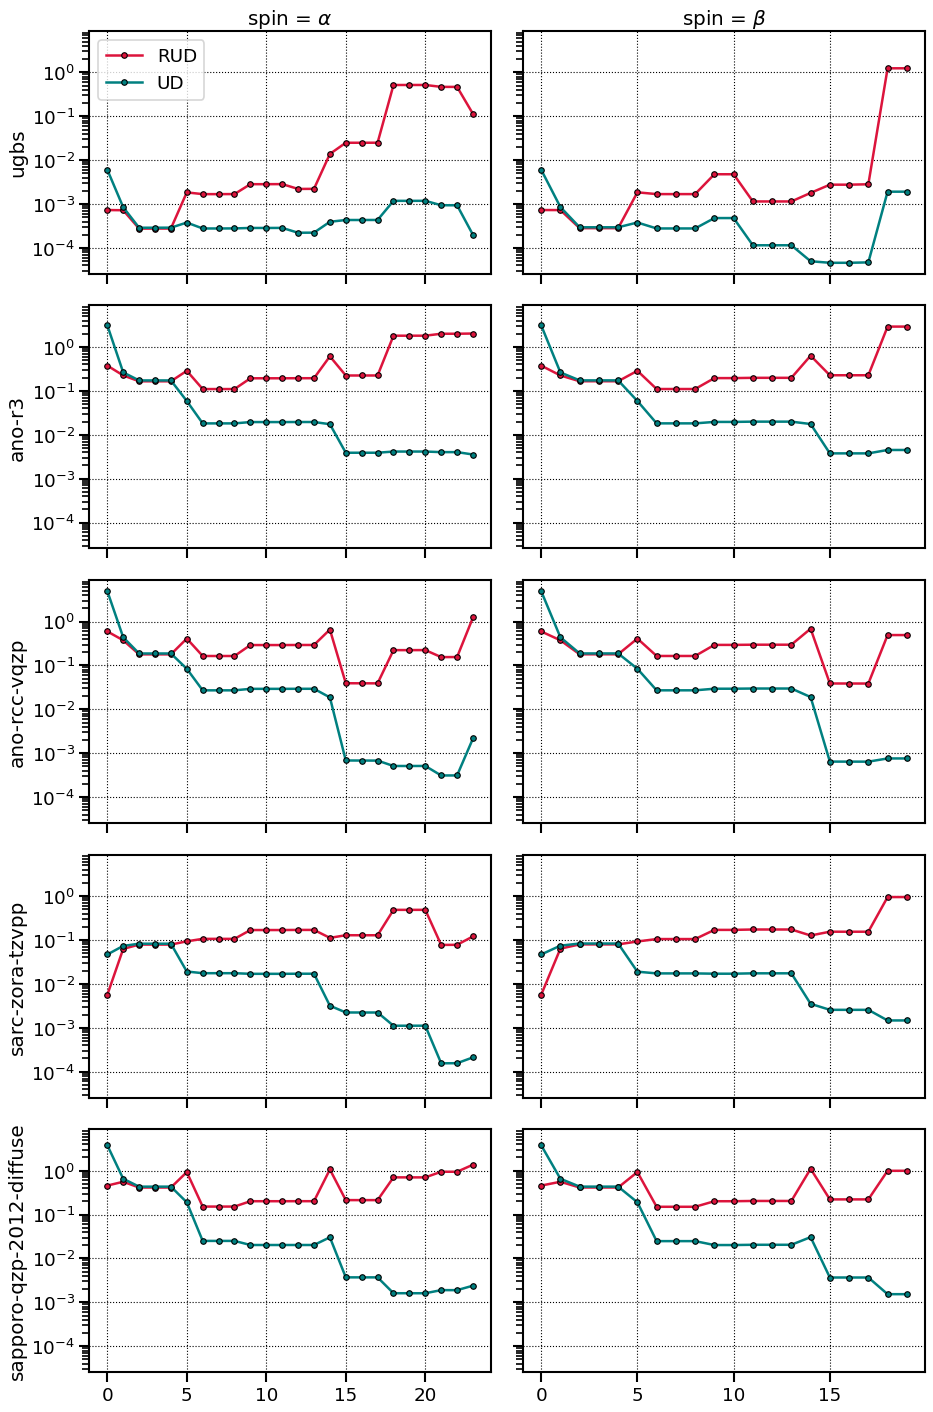

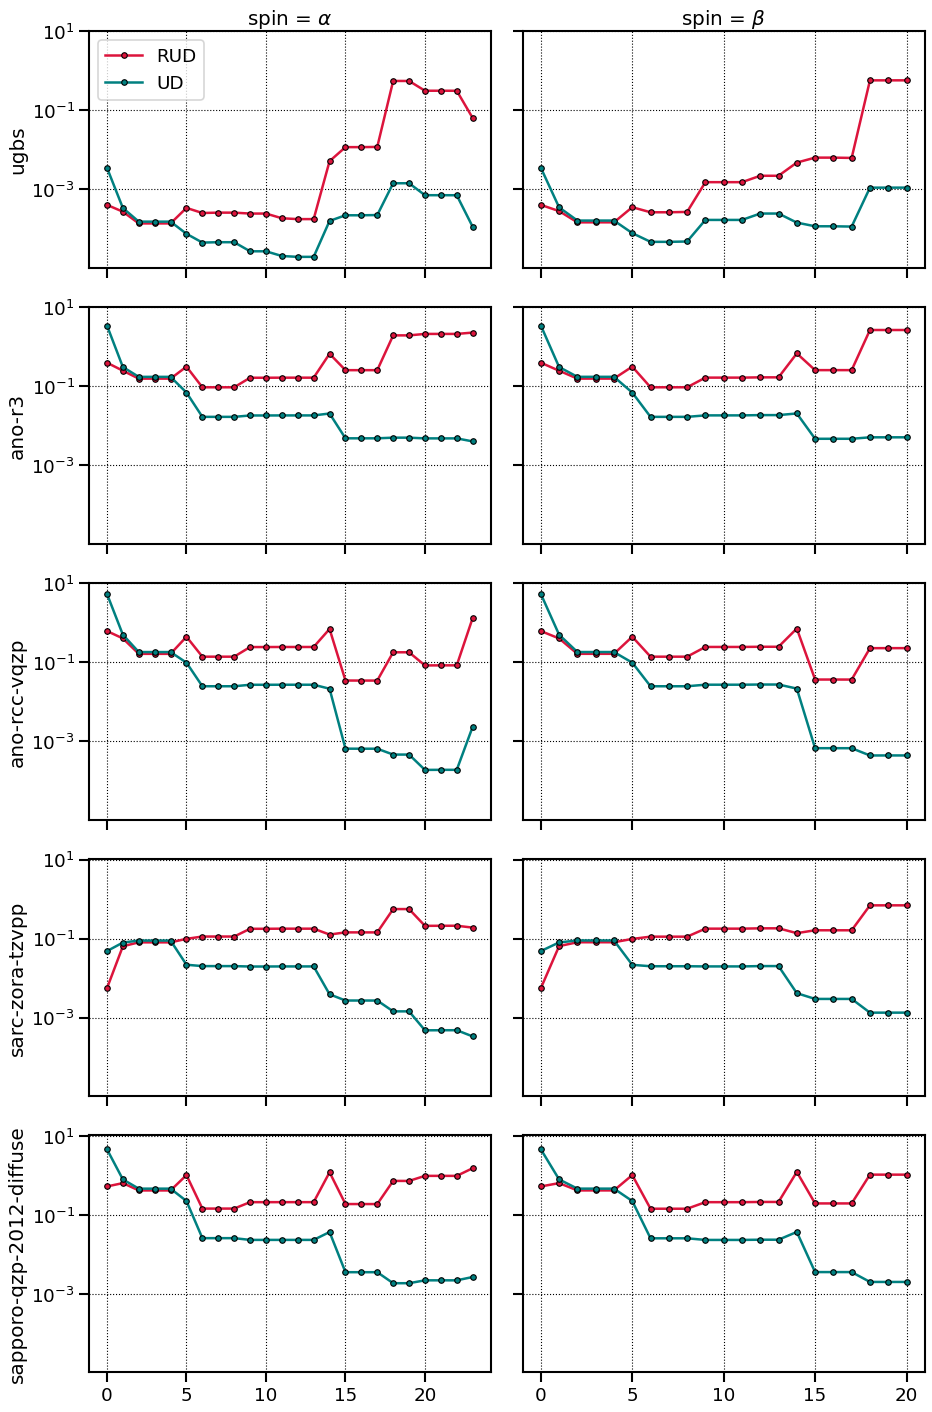

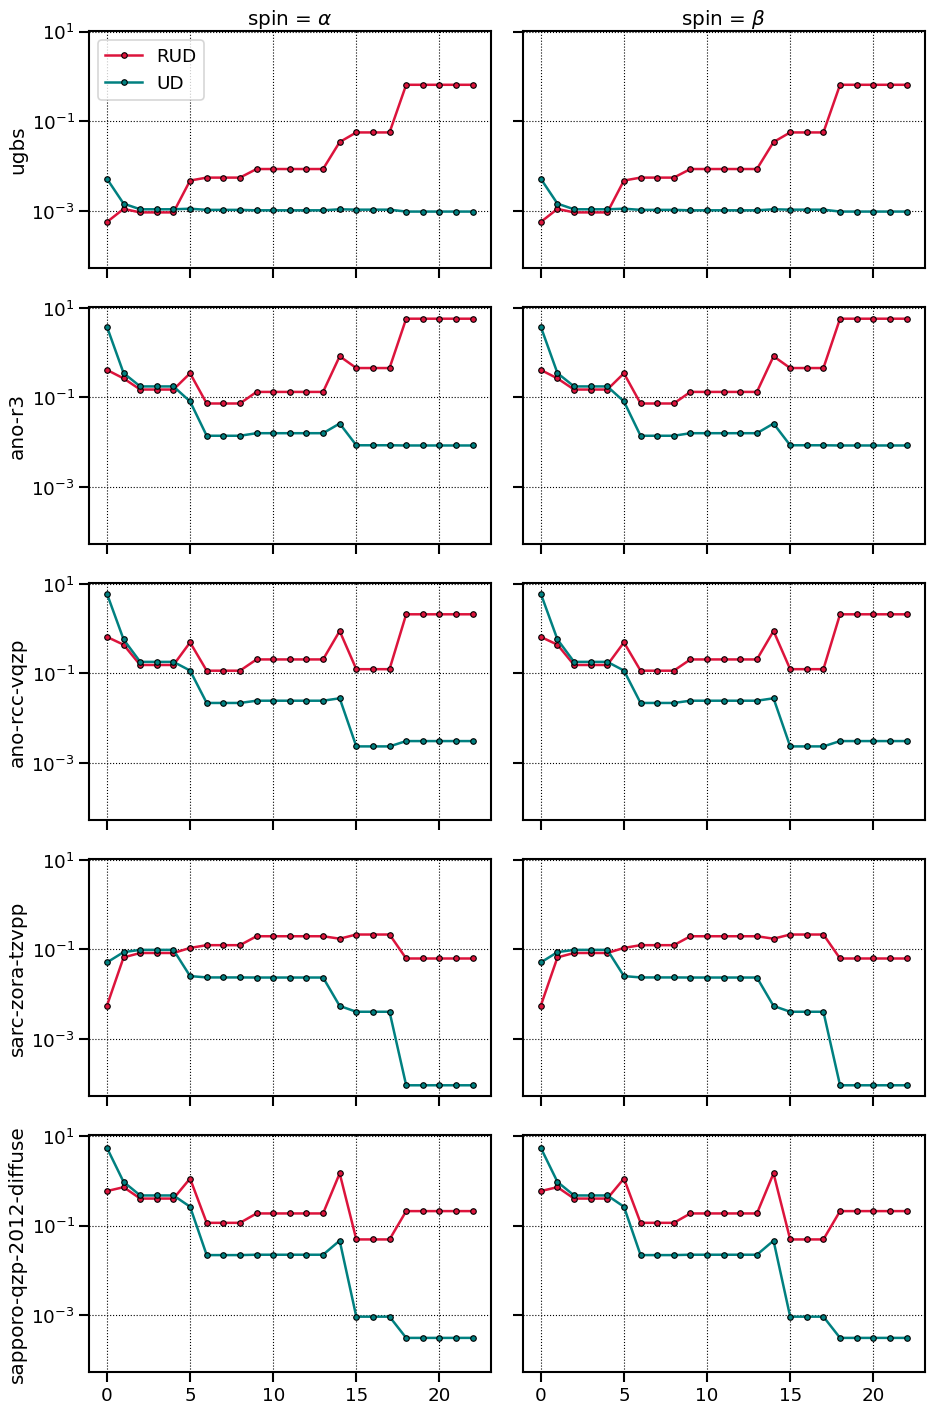

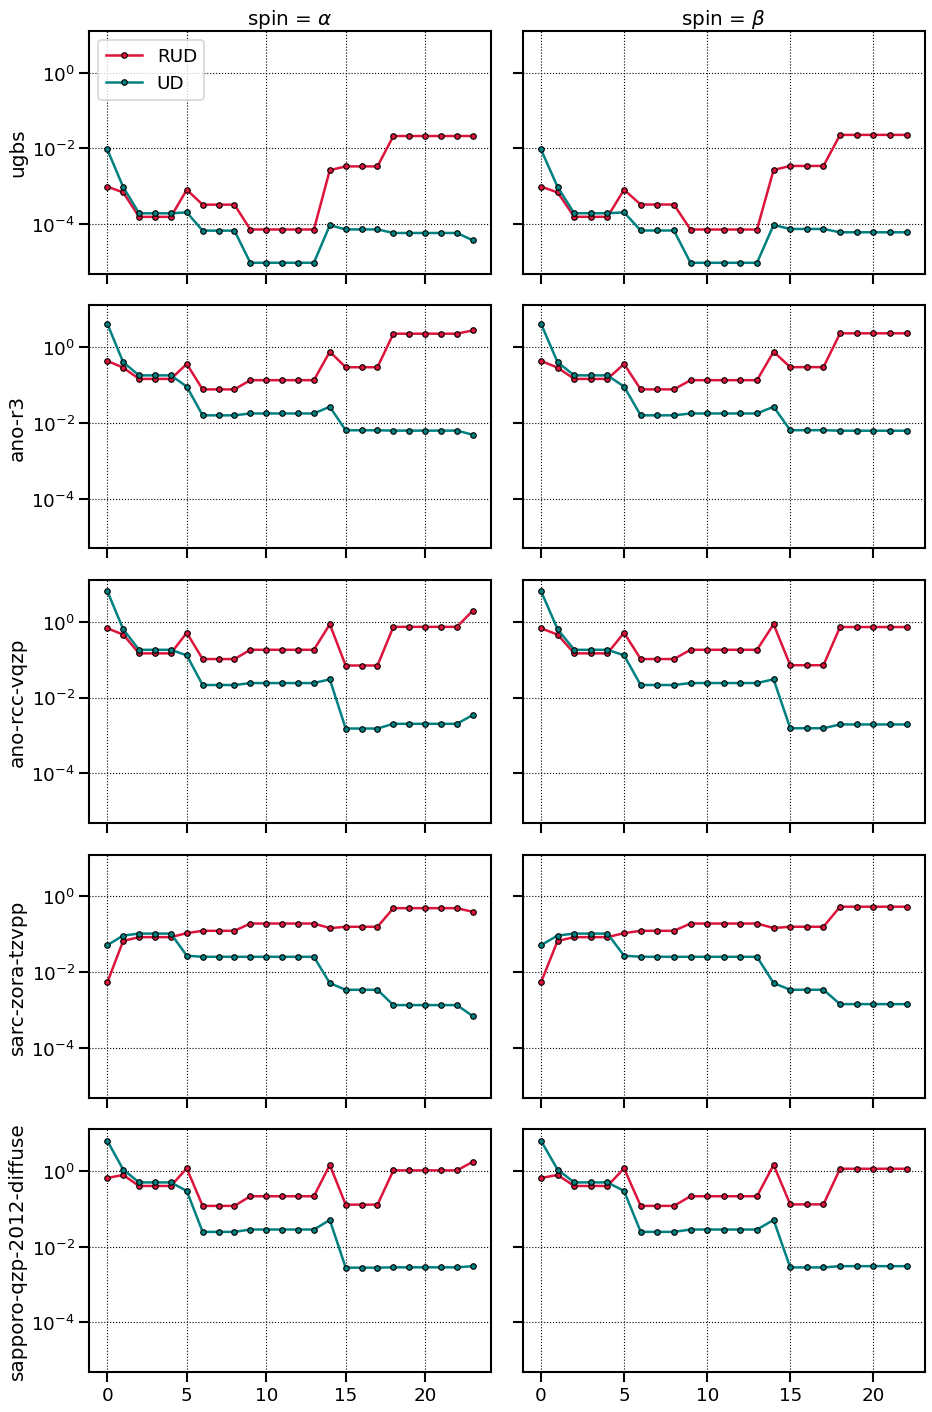

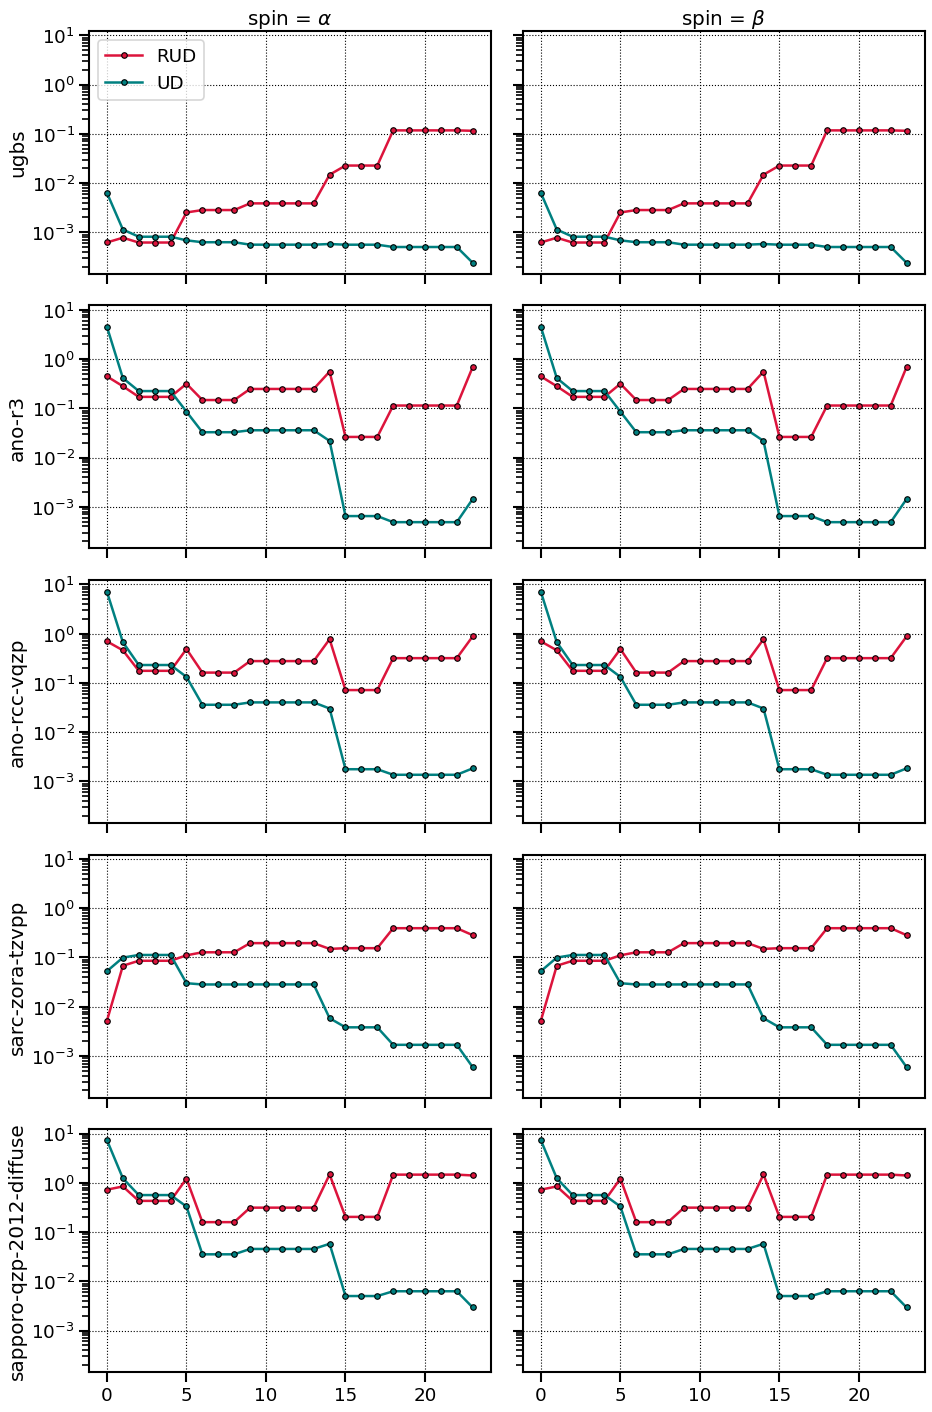

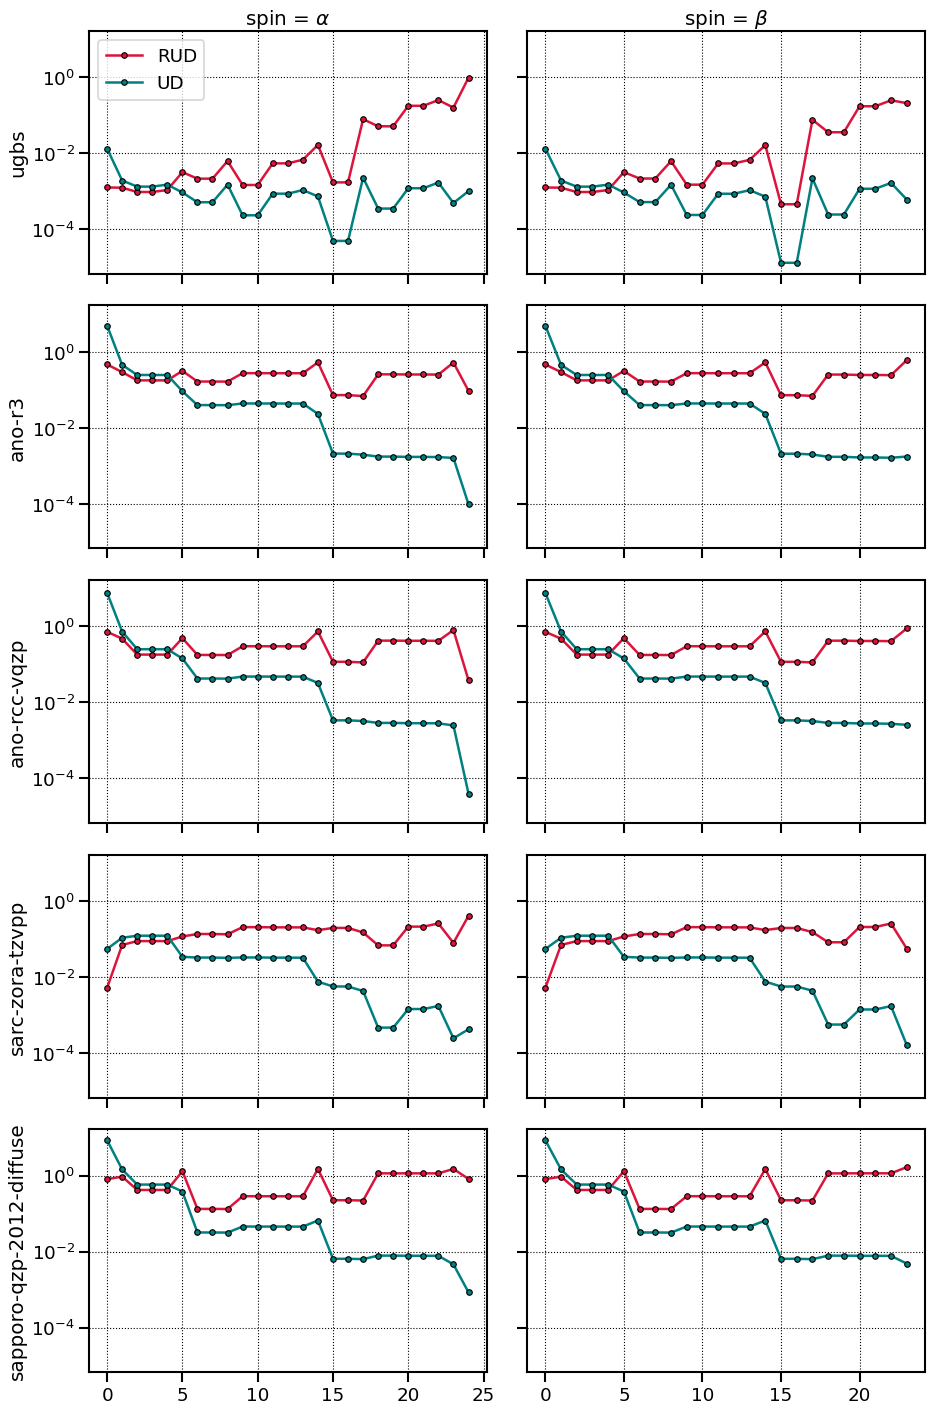

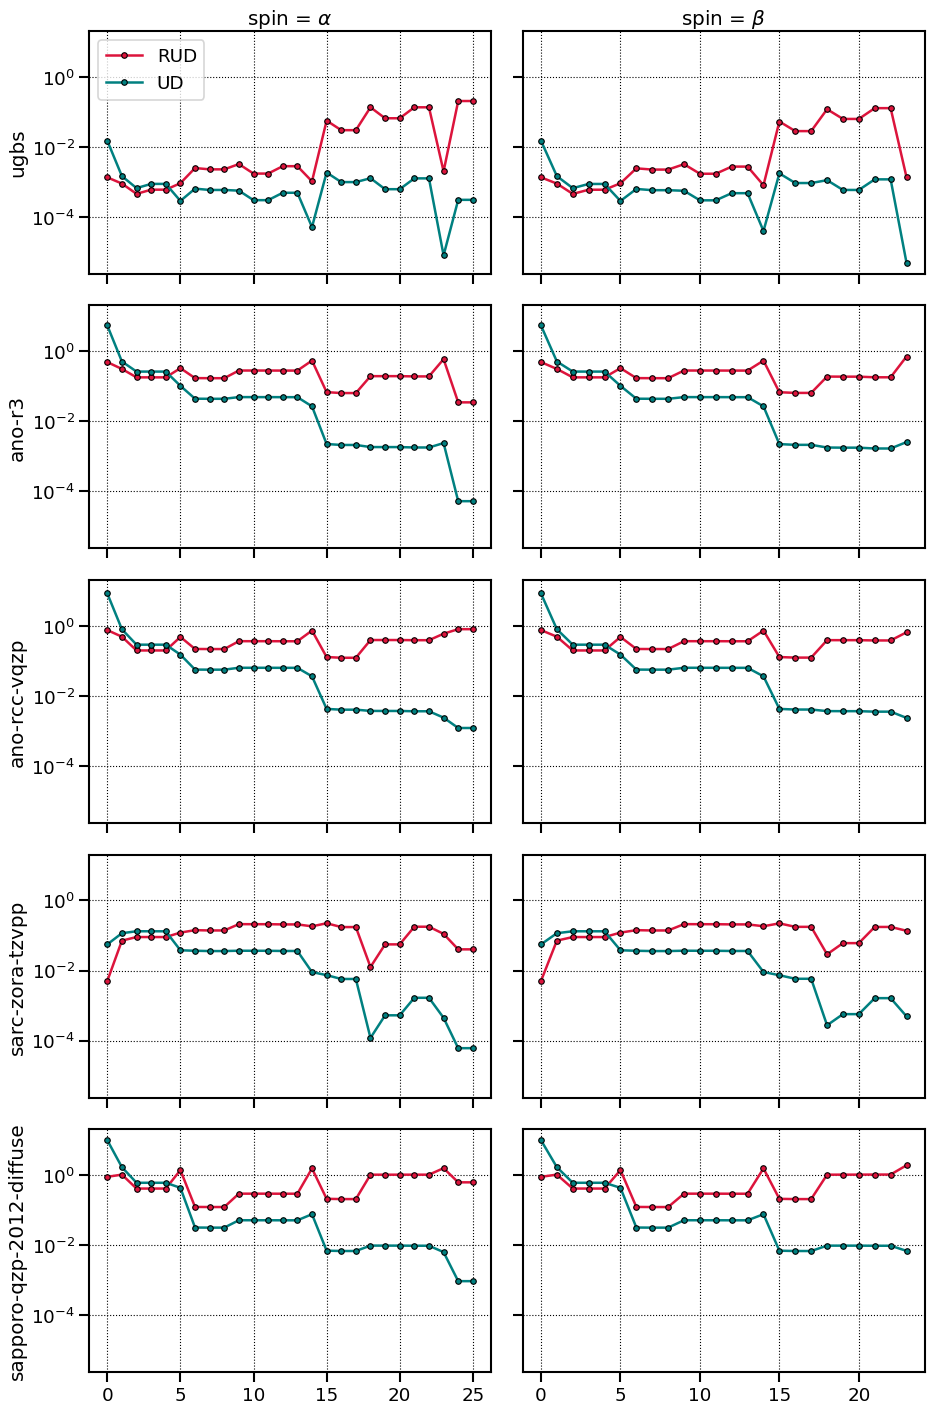

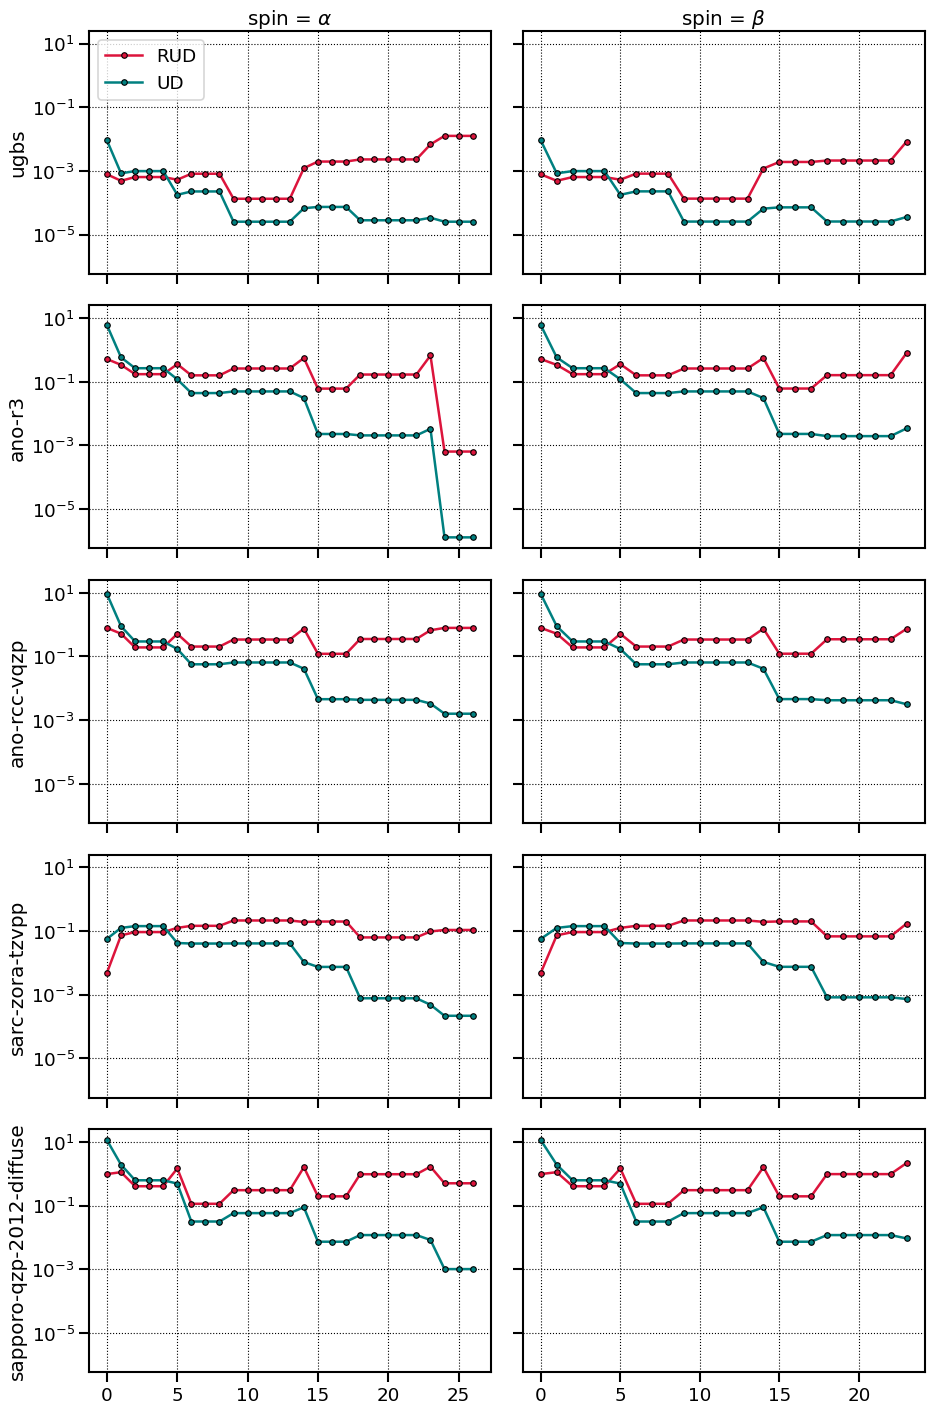

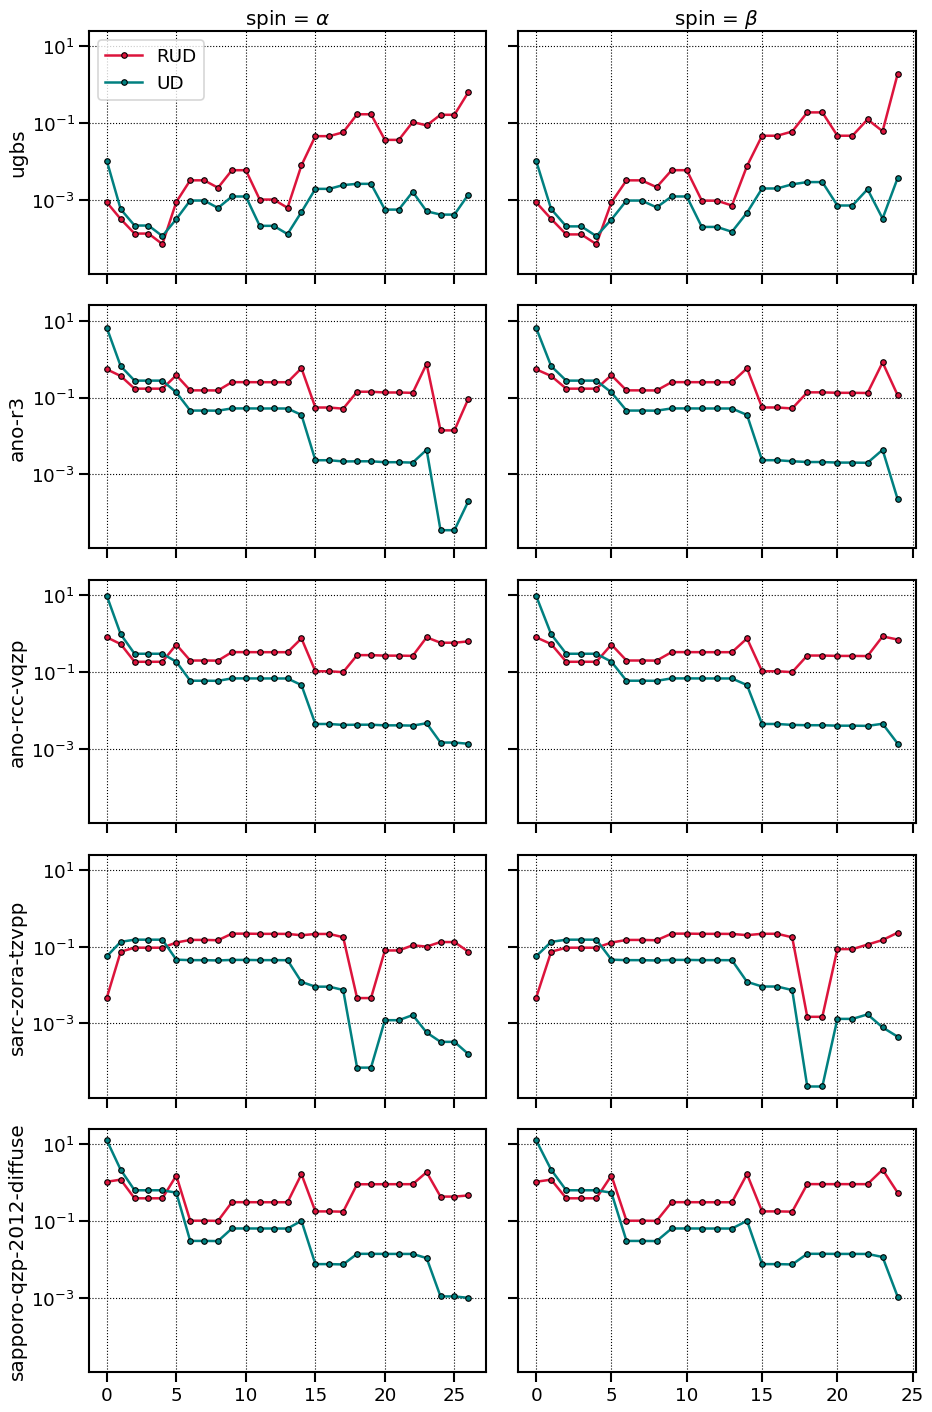

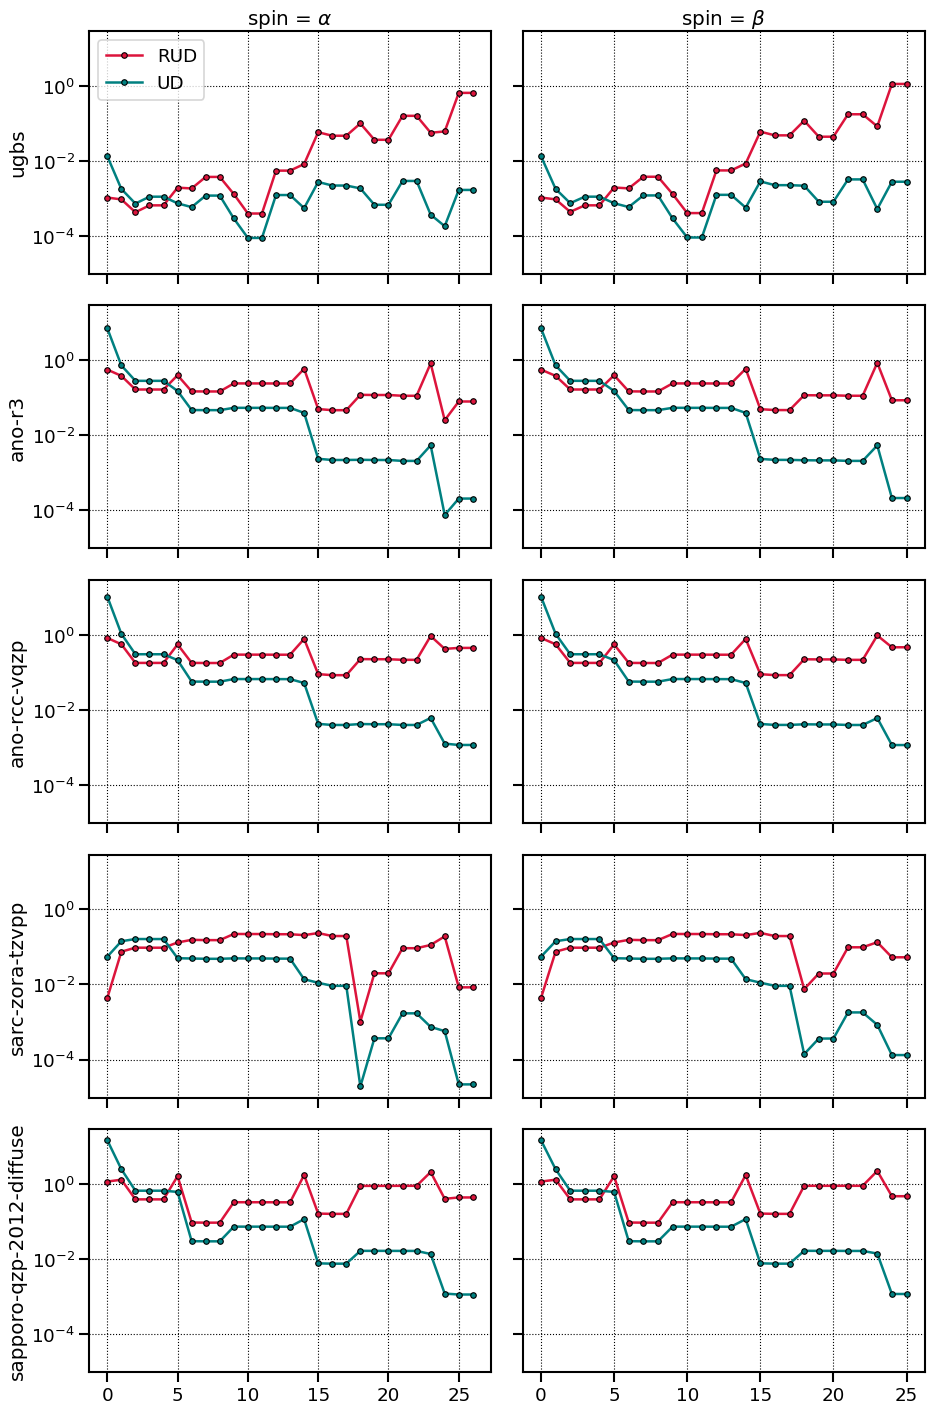

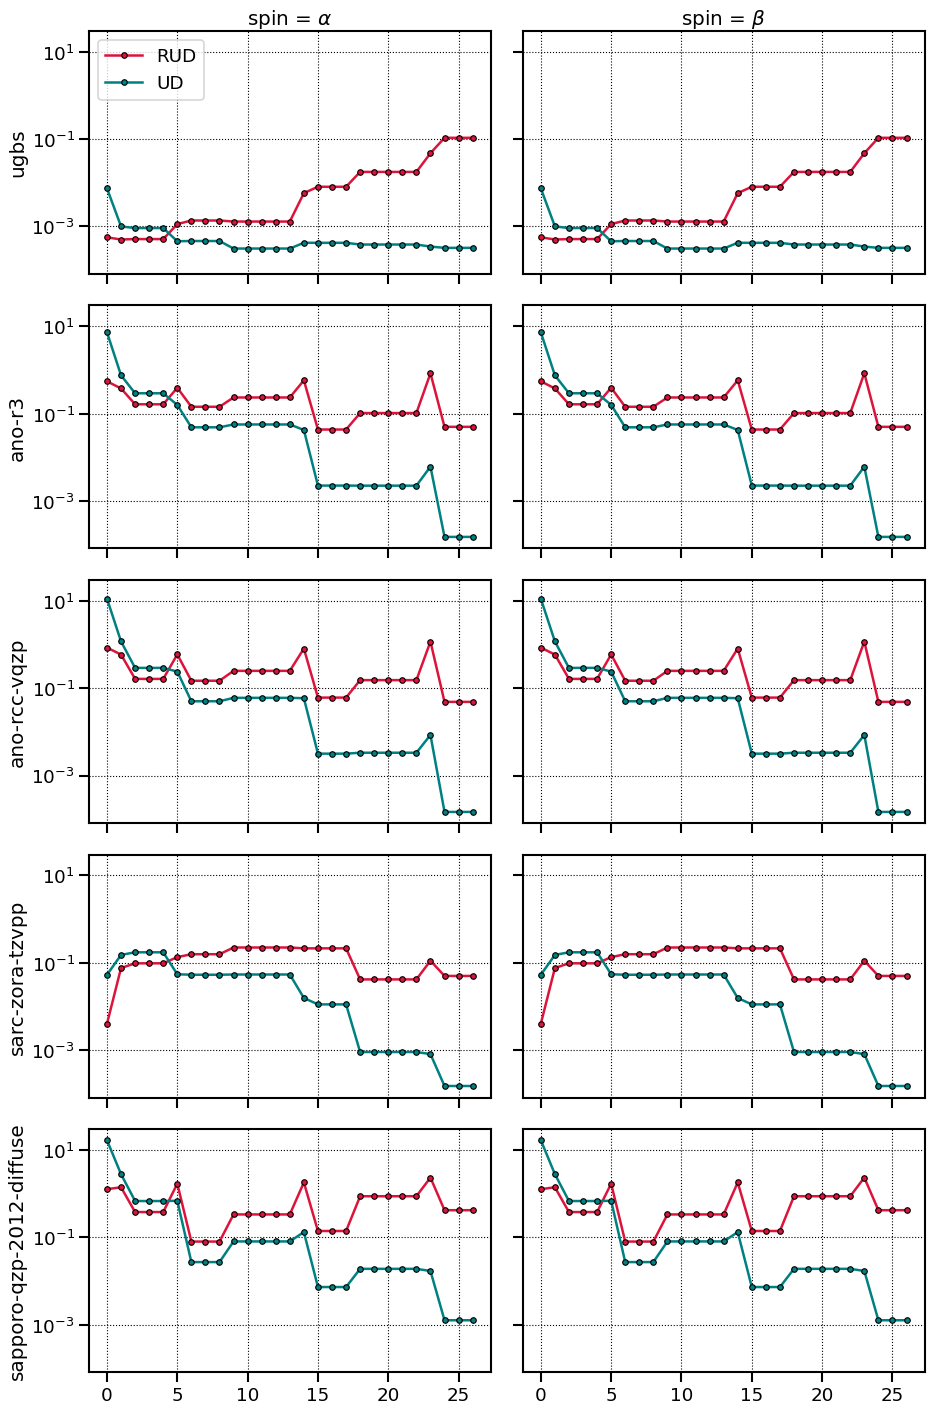

In [16]:
spins = ['a', 'b']
basis_sets=  ['ugbs', 'ano-r3', 'ano-rcc-vqzp', 'sarc-zora-tzvpp', 'sapporo-qzp-2012-diffuse']
atoms = [
 'Rb',
 'Sr',
 'Y',
 'Zr',
 'Nb',
 'Mo',
 'Tc',
 'Ru',
 'Rh',
 'Pd',
 'Ag',
 'Cd',
 'In',
 'Sn',
 'Sb',
 'Te',
 'I',
 'Xe'
]

for atom in atoms:
    # Print latex figure code
    code = f"""
    \\begin{{figure}}[H]
        \\centering
        \\includegraphics[height=0.75\\textheight]{{figs/gto_orbital_errors_{atom}.png}}
        \\caption{{Basis set errors presented as unsigned deviations (UD, green line, in Hartrees) and relative unsigned deviations (RUD, red line, in percent) in orbital energies for {atom}.}}
        \\label{{fig:orbital_errors_{atom}}}
    \\end{{figure}}
    """
    print(code)
    
    fig, axes = plt.subplots(dpi=80, figsize=(12, 18), ncols=2, nrows=5, sharey=True)
    for i, spin in enumerate(spins):
        for j, basis in enumerate(basis_sets):
            ax = axes[j, i]
            f_mw = f'calcs_zora_mw8_take1/{atom}_pbe.json'
            f_gto = f'calcs_zora_gto_defgrid3/{atom}_{basis}_pbe.out'

            if j != 4:
                ax.set_xticklabels([])

            ax.set_yscale('log')
            if i % 2 == 0:
                ax.set_ylabel(basis)

            if j == 0:
                if spin == 'a':
                    ax.set_title(r'spin = $\alpha$')
                else:
                    ax.set_title(r'spin = $\beta$')

            ax.grid(ls=':', lw=1, color='black')

            e_mw = np.asarray(mw_orbital_energies(f_mw)[spin])
            e_gto = np.asarray(gto_orbital_energies(f_gto)[spin])

            ud = np.abs(e_gto - e_mw)
            rud = np.abs(ud / e_mw * 100)

            ax.plot(rud, color='crimson', marker='o', mec='black', mew=1, ms=5, label='RUD')
            ax.plot(ud, color='teal', marker='o', mec='black', mew=1, ms=5, label='UD')

            if i == j == 0:
                ax.legend(loc='upper left')
                            
    fig.tight_layout()
    fig.savefig(f'figs_orbital_errors/gto_orbital_errors_{atom}.png', facecolor='white')